In [1]:
# In order to force the reload of modules
# %load_ext autoreload
# %autoreload 2

# In order to make the import of local modules
import sys
sys.path.append('../..')

from ml.rl.core import *

import abc
from collections import *
from dataclasses import *
import enum
import gym
import heapq
import numpy as np
import pandas as pd
import random
from tqdm import tqdm, trange
# from tqdm import tnrange, tqdm_notebook
from typing import *

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data

%matplotlib inline
import imageio
import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from PIL import Image

In [41]:
with gym.make("FrozenLake8x8-v0") as env:
    print(env.action_space)
    print(env.observation_space)
    print(env.__dict__)

    
def try_episode(agent: Agent):
    with gym.make("FrozenLake8x8-v0") as env:
        episode_reward = 0.
        done = False
        state = env.reset()
        while not done:
            action = agent.get_action(env, state)
            state, reward, done, _ = env.step(action)
            episode_reward += reward
        return episode_reward

Discrete(4)
Discrete(64)
{'env': <gym.envs.toy_text.frozen_lake.FrozenLakeEnv object at 0x11fdc6a20>, 'action_space': Discrete(4), 'observation_space': Discrete(64), 'reward_range': (0, 1), 'metadata': {'render.modes': ['human', 'ansi']}, 'spec': EnvSpec(FrozenLake8x8-v0), '_max_episode_seconds': None, '_max_episode_steps': 200, '_elapsed_steps': 0, '_episode_started_at': None}


6990/7000 (99.86%) - 409.88 it/ss


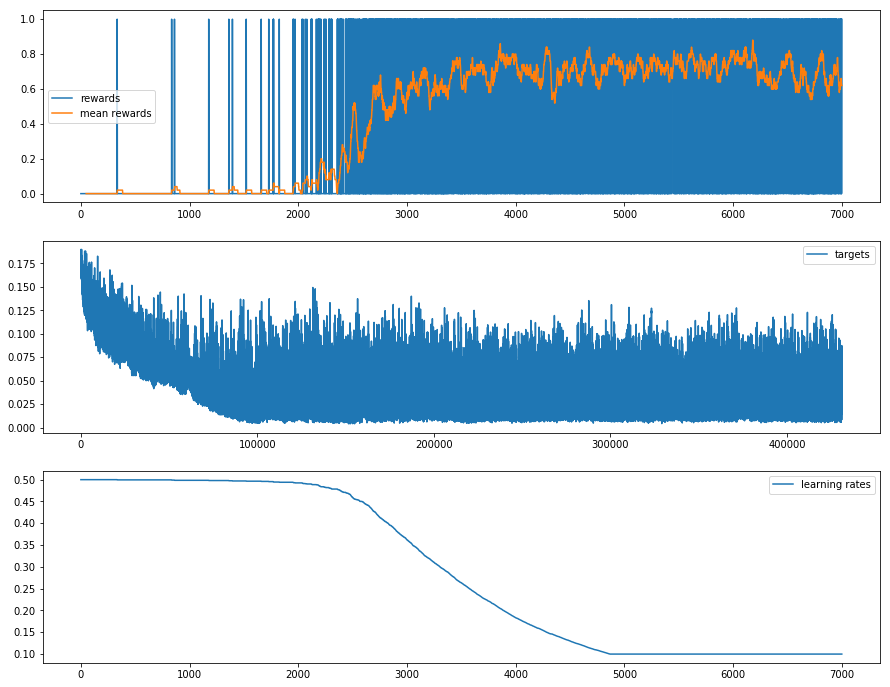

In [64]:
class QAgent(Agent):
    def __init__(self, q_values):
        self.q_values = q_values
    
    def get_action(self, env, state):
        return np.argmax(self.q_values[state])


def train_q_learning(env, episodes: int, learning_rate: float, learning_rate_decay: float, min_learning_rate: float,
                     discount: float, initial_q_value: float, epsilon: float, epsilon_decay: float,
                     show_stats=True) -> QAgent:
    
    episode_rewards = []
    targets = []
    learning_rates = []
    q_values = np.full(shape=(64, 4), fill_value=initial_q_value) # Initial value used to encourage exploration
    
    for _ in prange(episodes):
        episode_reward = 0.
        
        done = False
        state = env.reset()
        while not done:
            
            # Epsilon greedy action
            if np.random.rand(1) < epsilon:
                action = env.action_space.sample()
            else:
                action = np.argmax(q_values[state])
            
            # Execute the action
            next_state, reward, done, _ = env.step(action)
            episode_reward += reward
            
            # Bellman update
            if not done:
                target = reward + discount * np.max(q_values[next_state])
            else:
                target = reward
            q_values[state][action] += learning_rate * (target - q_values[state][action])
            targets.append(target)
            
            # Moving to next iteration
            state = next_state
        
        # Tracking success
        if episode_reward > 0:
            epsilon *= epsilon_decay
            learning_rate = max(min_learning_rate, learning_rate * learning_rate_decay)
        
        # Record history
        episode_rewards.append(episode_reward)
        learning_rates.append(learning_rate)
        
    # Reporting
    if show_stats:
        # print(q_values)
        fig, ax = plt.subplots(figsize=(15, 12), nrows=3)
        ax[0].plot(episode_rewards, label="rewards")
        ax[0].plot(pd.Series(episode_rewards).rolling(50).mean(), label="mean rewards")
        ax[1].plot(pd.Series(targets).rolling(20).sum() / 100., label="targets")
        ax[2].plot(learning_rates, label="learning rates")
        for p in ax:
            p.legend()
        plt.show()

    return QAgent(q_values)
    
    
"""
Training
"""


with gym.make("FrozenLake8x8-v0") as env:
    q_agent = train_q_learning(
        env, episodes=7_000,
        learning_rate=0.5, learning_rate_decay=0.999, min_learning_rate=0.1,
        discount=0.95,         # To encourage to find a short solution
        initial_q_value=1.,    # Speed up the learning at the beginning, but introduces bias
        epsilon=0.95, epsilon_decay=0.95)

In [65]:
success = 0.
count = 100
for _ in range(count):
    success += try_episode(q_agent)
print(success / count * 100, "%")

79.0 %


In [ ]:
# TODO - try to do it with convolution layers

In [ ]:
# TODO - try to do something similar but with a changing environment (idea of MCTS reward due to missing exploration)

In [ ]:
"""
Best agent should avoid being a Reflex Agent (only reacting to the current percept) because:
1. The environment is not known
2. The actions effect is not known

We need to create an agent with memory to learn how the actions work and to reconstruct the environment.
Then we can use the AND-OR tree search-like algorithm to find the safest path if it exists.
"""


class MemoryAgent(Agent):
    LEFT = 0
    DOWN = 1
    RIGHT = 2
    UP = 3
    
    def __init__(self):
        self.holes = set()
        self.goals = set()
    
    def get_action(self, env, state):
        # TODO - And-Or tree
        pass

    def train_on_episode(self, env) -> float:
        episode_reward = 0.
        done = False
        state = env.reset()
        while not done:
            action = self.get_action(env, state)
            state, reward, done, _ = env.step(action)
            if done:
                if reward > 0.:
                    self.goals.add(state)
                else:
                    self.holes.add(state)
            episode_reward += reward
        return episode_reward